**Outline of Steps**
    + Initialization
        + Download COCO detection data from http://cocodataset.org/#download
            + http://images.cocodataset.org/zips/train2014.zip <= train images
            + http://images.cocodataset.org/zips/val2014.zip <= validation images
            + http://images.cocodataset.org/annotations/annotations_trainval2014.zip <= train and validation annotations
        + Run this script to convert annotations in COCO format to VOC format
            + https://gist.github.com/chicham/6ed3842d0d2014987186#file-coco2pascal-py
        + Download pre-trained weights from https://pjreddie.com/darknet/yolo/
            + https://pjreddie.com/media/files/yolo.weights
        + Specify the directory of train annotations (train_annot_folder) and train images (train_image_folder)
        + Specify the directory of validation annotations (valid_annot_folder) and validation images (valid_image_folder)
        + Specity the path of pre-trained weights by setting variable *wt_path*
    + Construct equivalent network in Keras
        + Network arch from https://github.com/pjreddie/darknet/blob/master/cfg/yolo-voc.cfg
    + Load the pretrained weights
    + Perform training 
    + Perform detection on an image with newly trained weights
    + Perform detection on an video with newly trained weights

# Initialization

In [1]:
!pip install tqdm
from keras.models import Sequential, Model
import keras
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import imgaug as ia
from tqdm import tqdm
from imgaug import augmenters as iaa
import numpy as np
import pickle
import os, cv2
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes
from backend import TinyYoloFeature,MobileNetFeature

#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

%matplotlib inline

sess = tf.Session()

K.set_session(sess)
K.set_learning_phase(1)

    100% |████████████████████████████████| 51kB 566kB/s ta 0:00:01


Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14449972885265749204, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 177090974269352372
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17598562206748402242
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5692784640
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18264131723979815246
 physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
LABELS = ['station']

IMAGE_H, IMAGE_W = 224, 224
GRID_H,  GRID_W  = 7 , 7
#GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
#ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
ANCHORS          = [0.1,0.1,0.7,0.7,2,2,5,5,9,9]

# NO_OBJECT_SCALE  = 1.0
# OBJECT_SCALE     = 5.0
# COORD_SCALE      = 1.0
# CLASS_SCALE      = 1.0

NO_OBJECT_SCALE  = 0.1
OBJECT_SCALE     = 0.5
COORD_SCALE      = 3
CLASS_SCALE      = 1

BATCH_SIZE       = 4
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

In [4]:
wt_path = 'mobilenet_backend.h5'                      
train_image_folder = '/tf/data/final_docker_data4/stream_images_adj/'
train_annot_folder = '/tf/data/final_docker_data4/stream_images_adj_annotations/'
valid_image_folder = '/tf/data/final_docker_data4/stream_images_validation/'
valid_annot_folder = '/tf/data/final_docker_data4/stream_images_validation_annotations/'

# Construct the network

In [5]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [6]:
#input_image = Input(shape=(IMAGE_H, IMAGE_H, 3),name='input_1')

#self.labels   = list(labels)
#self.nb_class = len(self.labels)
nb_box   = len(ANCHORS)//2
# self.class_wt = np.ones(self.nb_class, dtype='float32')
# self.anchors  = anchors

max_box_per_image = TRUE_BOX_BUFFER
true_boxes = Input(shape=(1, 1, 1, max_box_per_image , 4),name='input_2')

feature_ext = MobileNetFeature(IMAGE_H)

grid_h, grid_w = feature_ext.get_output_shape()        
#features = feature_ext.extract(input_image)            
features = feature_ext.feature_extractor.output


# make the object detection layer
output = Conv2D(nb_box * (4 + 1 + len(LABELS)), 
                (1,1), strides=(1,1), 
                padding='same', 
                name='DetectionLayer', 
                kernel_initializer='lecun_normal')(features)
output = Reshape((grid_h, grid_w, nb_box, 4 + 1 + len(LABELS)))(output)
output = Lambda(lambda args: args[0])([output, true_boxes])

#model = Model([input_image, true_boxes], output)
model = Model([feature_ext.feature_extractor.input , true_boxes], output)

layer = model.layers[-4]
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(grid_h*grid_w)
new_bias   = np.random.normal(size=weights[1].shape)/(grid_h*grid_w)

layer.set_weights([new_kernel, new_bias])

W0422 04:02:05.114006 140626572662528 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/moving_averages.py:211: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


17227776/17225924 [==============================] - 2s 0us/step


In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
mobilenet_1.00_224 (Model)      (None, 7, 7, 1024)   3228864     input_1[0][0]                    
__________________________________________________________________________________________________
DetectionLayer (Conv2D)         (None, 7, 7, 30)     30750       mobilenet_1.00_224[1][0]         
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 7, 7, 5, 6)   0           DetectionLayer[0][0]             
__________________________________________________________________________________________________
input_2 (I

In [66]:
model.inputs

[<tf.Tensor 'input_3:0' shape=(?, 224, 224, 3) dtype=float32>,
 <tf.Tensor 'input_2_2:0' shape=(?, 1, 1, 1, 50, 4) dtype=float32>]

# Load pretrained weights

**Load the weights originally provided by YOLO**

In [67]:
weight_reader = WeightReader(wt_path)

In [68]:
# weight_reader.reset()
# nb_conv = 23

# for i in range(1, nb_conv+1):
#     conv_layer = model.get_layer('conv_' + str(i))
    
#     if i < nb_conv:
#         norm_layer = model.get_layer('norm_' + str(i))
        
#         size = np.prod(norm_layer.get_weights()[0].shape)

#         beta  = weight_reader.read_bytes(size)
#         gamma = weight_reader.read_bytes(size)
#         mean  = weight_reader.read_bytes(size)
#         var   = weight_reader.read_bytes(size)

#         weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
#     if len(conv_layer.get_weights()) > 1:
#         bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
#         kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
#         kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
#         kernel = kernel.transpose([2,3,1,0])
#         conv_layer.set_weights([kernel, bias])
#     else:
#         kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
#         kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
#         kernel = kernel.transpose([2,3,1,0])
#         conv_layer.set_weights([kernel])

**Randomize weights of the last layer**

In [69]:
# layer   = model.layers[-4] # the last convolutional layer
# weights = layer.get_weights()

# new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
# new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

# layer.set_weights([new_kernel, new_bias])

# Perform training

**Loss function**

$$\begin{multline}
\lambda_\textbf{coord}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
     L_{ij}^{\text{obj}}
            \left[
            \left(
                x_i - \hat{x}_i
            \right)^2 +
            \left(
                y_i - \hat{y}_i
            \right)^2
            \right]
\\
+ \lambda_\textbf{coord} 
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
         L_{ij}^{\text{obj}}
         \left[
        \left(
            \sqrt{w_i} - \sqrt{\hat{w}_i}
        \right)^2 +
        \left(
            \sqrt{h_i} - \sqrt{\hat{h}_i}
        \right)^2
        \right]
\\
+ \sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
        L_{ij}^{\text{obj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \lambda_\textrm{noobj}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
    L_{ij}^{\text{noobj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \sum_{i = 0}^{S^2}
L_i^{\text{obj}}
    \sum_{c \in \textrm{classes}}
        \left(
            p_i(c) - \hat{p}_i(c)
        \right)^2
\end{multline}$$

In [70]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

**Parse the annotations to construct train generator and validation generator**

In [71]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

In [8]:
def normalize(image):
    return image / 255.

In [73]:
train_imgs, seen_train_labels = parse_annotation(train_annot_folder, train_image_folder, labels=LABELS)
### write parsed annotations to pickle for fast retrieval next time
#with open('train_imgs', 'wb') as fp:
#    pickle.dump(train_imgs, fp)

### read saved pickle of parsed annotations
#with open ('train_imgs', 'rb') as fp:
#    train_imgs = pickle.load(fp)
train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)

valid_imgs, seen_valid_labels = parse_annotation(valid_annot_folder, valid_image_folder, labels=LABELS)
### write parsed annotations to pickle for fast retrieval next time
#with open('valid_imgs', 'wb') as fp:
#    pickle.dump(valid_imgs, fp)

### read saved pickle of parsed annotations
#with open ('valid_imgs', 'rb') as fp:
#    valid_imgs = pickle.load(fp)
valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize, jitter=False)

**Setup a few callbacks and start the training**

In [74]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=7, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('yolo_mobilenet_weightsv11.hd5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [77]:
tb_counter  = len([log for log in os.listdir(os.path.expanduser('./logs/')) if 'coco_' in log]) + 1
tensorboard = TensorBoard(log_dir=os.path.expanduser('./logs/') + 'coco_' + '_' + str(tb_counter), 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=False)

optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)

model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 35, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [early_stop, checkpoint, tensorboard], 
                    max_queue_size   = 3)

Epoch 1/35
3381/3381 [==============================] - 675s 200ms/step - loss: 0.1194 - val_loss: 0.1230

Epoch 00001: val_loss improved from inf to 0.12298, saving model to yolo_mobilenet_weightsv11.hd5
Epoch 2/35
3381/3381 [==============================] - 679s 201ms/step - loss: 0.1149 - val_loss: 0.1158

Epoch 00002: val_loss improved from 0.12298 to 0.11576, saving model to yolo_mobilenet_weightsv11.hd5
Epoch 3/35
3381/3381 [==============================] - 670s 198ms/step - loss: 0.1155 - val_loss: 0.1191

Epoch 00003: val_loss did not improve from 0.11576
Epoch 4/35
3381/3381 [==============================] - 680s 201ms/step - loss: 0.1096 - val_loss: 0.1201

Epoch 00004: val_loss did not improve from 0.11576
Epoch 5/35
3381/3381 [==============================] - 673s 199ms/step - loss: 0.1104 - val_loss: 0.1075

Epoch 00005: val_loss improved from 0.11576 to 0.10753, saving model to yolo_mobilenet_weightsv11.hd5
Epoch 6/35
3381/3381 [==============================] - 681s 

KeyboardInterrupt: 

# Perform detection on image

In [9]:
model.load_weights("yolo_mobilenet_weightsv11.hd5")

In [19]:
### idx = 500
#image = cv2.imread('/tf/data/stream3_images/'+str(idx)+'.jpg')
#idx = 100
#idx = 1000
#idx = 4000
#idx = 1325
idx = 300
image = cv2.imread('/tf/data/data/stream_training/'+str(idx)+'.jpg')
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=0.5,
                      nms_threshold=0.3,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

error: OpenCV(4.0.0) /io/opencv/modules/imgproc/src/resize.cpp:3784: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


<Figure size 720x720 with 0 Axes>

In [526]:
boxes[1].score

0.8173381

# Perform detection on video

In [18]:
model.load_weights("weights_coco_mobilenetv5.h5")

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

In [53]:
video_inp = '/tf/data/stream3.mp4'
video_out = '/tf/data/stream3_predicted.mp4'

video_reader = cv2.VideoCapture(video_inp)

nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

video_writer = cv2.VideoWriter(video_out,
                               cv2.VideoWriter_fourcc(*'XVID'), 
                               50.0, 
                               (frame_w, frame_h))

for i in tqdm(range(nb_frames)):
    ret, image = video_reader.read()
    
    input_image = cv2.resize(image, (224, 224))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    netout = model.predict([input_image, dummy_array])

    boxes = decode_netout(netout[0], 
                          obj_threshold=0.5,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    image = draw_boxes(image, boxes, labels=LABELS)

    video_writer.write(np.uint8(image))
    
video_reader.release()
video_writer.release()  

100%|██████████| 10794/10794 [02:38<00:00, 68.16it/s]


In [168]:
a = boxes[0]

In [47]:
max_score = -1
saved_box = []
for bbox in boxes:
    if bbox.get_score()>max_score:
        saved_box = bbox

In [20]:
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, 1, 1, 1, 50, 4) dtype=float32>]
[<tf.Tensor 'lambda_1/Identity:0' shape=(?, 7, 7, 5, 6) dtype=float32>]


In [10]:
K.set_learning_phase(0)  # all new operations will be in test mode from now on

config = model.to_json()
weights = model.get_weights()

import pickle
with open('yolo_mobilenet_weights_v11_v2.cfg','wb') as f:
    pickle.dump(config,f)
with open('yolo_mobilenet_weights_v11_v2.hd5','wb') as f:
    pickle.dump(weights,f)
#del model

# from keras.models import model_from_json
# new_model = model_from_json(config)
# new_model.set_weights(weights)

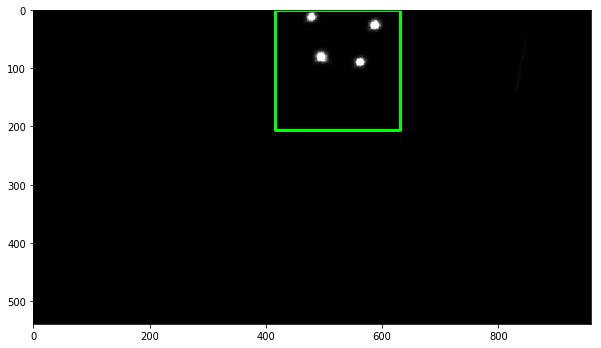

In [265]:
#idx = 500
#image = cv2.imread('/tf/data/stream3_images/'+str(idx)+'.jpg')
idx = idx - 10
image = cv2.imread('/tf/data/stream2/'+str(idx)+'.jpg')
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=0.5,
                      nms_threshold=0.3,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

In [81]:
model.outputs

[<tf.Tensor 'lambda_2/Identity:0' shape=(?, 7, 7, 5, 6) dtype=float32>]

In [79]:
model.inputs

[<tf.Tensor 'input_3:0' shape=(?, 224, 224, 3) dtype=float32>,
 <tf.Tensor 'input_2_2:0' shape=(?, 1, 1, 1, 50, 4) dtype=float32>]